## Amazon  ML Hiring Challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
from tqdm import tqdm
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


import sklearn
from sklearn.metrics import precision_recall_curve, auc, roc_curve, hamming_loss, log_loss, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics.classification import accuracy_score, log_loss
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
import tensorflow as tf
from keras import backend as K

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate, Flatten
from tensorflow.keras.layers import LSTM,MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal
from keras.layers.normalization import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.regularizers import L1L2


import pickle
import gc

Using TensorFlow backend.


In [2]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10, 8)})

### Reading data and basic stats 

In [3]:
with open('df_train.pkl', 'rb') as fp:   # for loading a pickle file.
    df_train = pickle.load(fp)
with open('df_test.pkl', 'rb') as fp:   # for loading a pickle file.
    df_test = pickle.load(fp)

In [4]:
#df_train = pd.read_csv("df_train_mf.csv", encoding='utf-8')
#df_test = pd.read_csv("df_test_mf.csv", encoding='utf-8')

print("Number of data points in Train:",df_train.shape[0])
print("Number of data points in Test:",df_test.shape[0])

print(df_train.info())
print(df_test.info())

df_train.head()

Number of data points in Train: 5959
Number of data points in Test: 2553
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 5 columns):
Review Text                  5959 non-null object
Review Title                 5959 non-null object
topic                        5959 non-null object
Preprocessed_Review_Text     5959 non-null object
Preprocessed_Review_Title    5959 non-null object
dtypes: object(5)
memory usage: 232.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 4 columns):
Review Text                  2553 non-null object
Review Title                 2553 non-null object
Preprocessed_Review_Text     2553 non-null object
Preprocessed_Review_Title    2553 non-null object
dtypes: object(4)
memory usage: 79.9+ KB
None


Review Text  \
0  Did nothing for me, didn't help lost even with...   
1  Did nothing for me, didn't help lost even with...   
2  I have bought these bags and  immediately open...   
3         Gave me an allergic reaction on my face :(   
4  These don't compare to the name brand wipes. F...   

                                        Review Title                  topic  \
0                                            Useless  Shipment and delivery   
1                                            Useless          Not Effective   
2  TRASH!!! Do not buy these bags it’s a waist of...       Customer Service   
3                                   Do not recommend               Allergic   
4                            Can't tackle big messes                Texture   

                            Preprocessed_Review_Text  \
0  nothing not help lost even working eating heal...   
1  nothing not help lost even working eating heal...   
2  bought bag immediately open one put trash bag ...   
3                        gave allergic reaction face   
4  not compare name brand wipe family little kid ...   

      Preprocessed_Review_Title  
0                       useless  
1                       useless  
2  trash not buy bag waist time  
3                 not recommend  
4        ca not tackle big mess

In [5]:
df_train[df_train.isna().any(axis=1)]

Empty DataFrame
Columns: [Review Text, Review Title, topic, Preprocessed_Review_Text, Preprocessed_Review_Title]
Index: []

In [6]:
df_test[df_test.isnull().any(axis=1)]

Empty DataFrame
Columns: [Review Text, Review Title, Preprocessed_Review_Text, Preprocessed_Review_Title]
Index: []

In [7]:
#Combining review and title.
df_train['review_and_title_preprocessed'] = df_train['Preprocessed_Review_Text'] + " " + df_train['Preprocessed_Review_Title']
df_test['review_and_title_preprocessed'] = df_test['Preprocessed_Review_Text'] + " " + df_test['Preprocessed_Review_Title']

In [8]:
#Converting labels to label encoded values.
LE = LabelEncoder()
y_true = LE.fit_transform(df_train['topic'])
#y_true = df_train['topic']

In [12]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_cv, y_train, y_cv = train_test_split(df_train, y_true, stratify=y_true, test_size=0.3, random_state=55)

<h3> TFIDF vectorization </h3>

<h4> TFIDF vectorization for X_train </h4>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#X_train_text = list(X_train['Review Text']) + list(X_train['Review Title'])
X_train_text = X_train['review_and_title_preprocessed'].values
X_cv_text = X_cv['review_and_title_preprocessed'].values

tfidf = TfidfVectorizer(lowercase=False, min_df=0.005, analyzer='word', ngram_range=(1, 2), encoding='utf-8')
X_train_text_tfidf = tfidf.fit(X_train_text)

In [11]:
X_train_sdf1 = pd.SparseDataFrame(X_train_text_tfidf.transform(X_train['Preprocessed_Review_Text']),
                         columns=X_train_text_tfidf.get_feature_names(), 
                         default_fill_value=0)
X_train_sdf1.head(2)

able  absolutely  acid  actually  add  added  aftertaste  ago  allergic  \
0   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   
1   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   

   allergic reaction  ...  worse  worst  worth     would  would not  wrong  \
0                0.0  ...    0.0    0.0    0.0  0.000000        0.0    0.0   
1                0.0  ...    0.0    0.0    0.0  0.147717        0.0    0.0   

   wrong item  wrong product  year  yet  
0         0.0            0.0   0.0  0.0  
1         0.0            0.0   0.0  0.0  

[2 rows x 580 columns]

In [12]:
X_train_sdf2 = pd.SparseDataFrame(X_train_text_tfidf.transform(X_train['Preprocessed_Review_Title']),
                         columns=X_train_text_tfidf.get_feature_names(), 
                         default_fill_value=0)
X_train_sdf2.head(2)

able  absolutely  acid  actually  add  added  aftertaste  ago  allergic  \
0   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   
1   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   

   allergic reaction  ...  worse  worst  worth  would  would not  wrong  \
0                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   
1                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   

   wrong item  wrong product  year  yet  
0         0.0            0.0   0.0  0.0  
1         0.0            0.0   0.0  0.0  

[2 rows x 580 columns]

<h4> TFIDF vectorization for X_cv </h4>

In [13]:
X_cv_sdf1 = pd.SparseDataFrame(X_train_text_tfidf.transform(X_cv['Preprocessed_Review_Text']),
                         columns=X_train_text_tfidf.get_feature_names(), 
                         default_fill_value=0)
X_cv_sdf1.head(2)

able  absolutely  acid  actually  add  added  aftertaste  ago  allergic  \
0   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   
1   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   

   allergic reaction  ...  worse  worst  worth  would  would not  wrong  \
0                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   
1                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   

   wrong item  wrong product  year  yet  
0         0.0            0.0   0.0  0.0  
1         0.0            0.0   0.0  0.0  

[2 rows x 580 columns]

In [14]:
X_cv_sdf2 = pd.SparseDataFrame(X_train_text_tfidf.transform(X_cv['Preprocessed_Review_Title']),
                         columns=X_train_text_tfidf.get_feature_names(), 
                         default_fill_value=0)
X_cv_sdf2.head(2)

able  absolutely  acid  actually  add  added  aftertaste  ago  allergic  \
0   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   
1   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   

   allergic reaction  ...  worse  worst  worth  would  would not  wrong  \
0                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   
1                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   

   wrong item  wrong product  year  yet  
0         0.0            0.0   0.0  0.0  
1         0.0            0.0   0.0  0.0  

[2 rows x 580 columns]

<h4> TFIDF vectorization for test </h4>

In [15]:
X_test_sdf1 = pd.SparseDataFrame(X_train_text_tfidf.transform(df_test['Preprocessed_Review_Text']),
                         columns=X_train_text_tfidf.get_feature_names(), 
                         default_fill_value=0)
X_test_sdf1.head(2)

able  absolutely  acid  actually  add  added  aftertaste  ago  allergic  \
0   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   
1   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   

   allergic reaction  ...  worse  worst  worth  would  would not  wrong  \
0                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   
1                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   

   wrong item  wrong product  year  yet  
0         0.0            0.0   0.0  0.0  
1         0.0            0.0   0.0  0.0  

[2 rows x 580 columns]

In [16]:
X_test_sdf2 = pd.SparseDataFrame(X_train_text_tfidf.transform(df_test['Preprocessed_Review_Title']),
                         columns=X_train_text_tfidf.get_feature_names(), 
                         default_fill_value=0)
X_test_sdf2.head(2)

able  absolutely  acid  actually  add  added  aftertaste  ago  allergic  \
0   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   
1   0.0         0.0   0.0       0.0  0.0    0.0         0.0  0.0       0.0   

   allergic reaction  ...  worse  worst  worth  would  would not  wrong  \
0                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   
1                0.0  ...    0.0    0.0    0.0    0.0        0.0    0.0   

   wrong item  wrong product  year  yet  
0         0.0            0.0   0.0  0.0  
1         0.0            0.0   0.0  0.0  

[2 rows x 580 columns]

### Stacking all the features

In [17]:
X_train_vectorized = np.hstack((X_train_sdf2.values, X_train_sdf1.values))#, X_train[X_train.columns[3:]].values))
X_train_vectorized.shape

(4171, 1160)

In [18]:
X_cv_vectorized = np.hstack((X_cv_sdf2.values, X_cv_sdf1.values))#, X_cv[X_cv.columns[3:]].values))
X_cv_vectorized.shape

(1788, 1160)

In [19]:
X_test_vectorized = np.hstack((X_test_sdf2.values, X_test_sdf1.values))#, df_test[df_test.columns[2:]].values))
X_test_vectorized.shape

(2553, 1160)

### Standardizing all the datasets

### Logistic regression using OneVsRestClassifier

In [20]:
(X_train_vectorized==np.nan).any()

False

In [25]:
start = dt.datetime.now()
param_grid  = {"estimator__alpha": [10**i for i in range(-9,2)]}

classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1')) #SGDClassifier with log loss is Logistic regression.
#classifier = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=300)
model = GridSearchCV(classifier,param_grid, 
                     scoring={'neg_log_loss', 'accuracy'}, 
                     refit='neg_log_loss', # Because we are using multiple scoring metrics
                     cv=StratifiedKFold(3, shuffle=True), # Because some class labels are imbalanced
                     return_train_score=True,
                     verbose=2, n_jobs=-1)
model.fit(X_train_vectorized, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   26.9s finished
C:\Users\avinash\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score=True, scoring={'accuracy', 'neg_log_loss'},
       verbose=2)

In [22]:
def evaluation(model, X_cv_vectorized, y_cv):
    cccv_lr_model = CalibratedClassifierCV(model, cv='prefit').fit(X_cv_vectorized, y_cv)
    global y_pred
    y_pred = cccv_lr_model.predict(X_cv_vectorized)
    #y_pred = model.predict(X_cv_vectorized)

    print("Accuracy :",accuracy_score(y_cv, y_pred))
    print("Hamming loss ",hamming_loss(y_cv,y_pred))
    #print("Log loss ",log_loss(y_cv,y_pred))

    precision = precision_score(y_cv, y_pred, average='micro')
    recall = recall_score(y_cv, y_pred, average='micro')
    f1 = f1_score(y_cv, y_pred, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    precision = precision_score(y_cv, y_pred, average='macro')
    recall = recall_score(y_cv, y_pred, average='macro')
    f1 = f1_score(y_cv, y_pred, average='macro')

    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    print (classification_report(y_cv, y_pred))


    print("Time taken to run this cell :", dt.datetime.now() - start)

In [27]:
evaluation(model, X_cv_vectorized, y_cv)

Accuracy : 0.5682326621923938
Hamming loss  0.4317673378076063
Micro-average quality numbers
Precision: 0.5682, Recall: 0.5682, F1-measure: 0.5682
Macro-average quality numbers
Precision: 0.4706, Recall: 0.4087, F1-measure: 0.4293
              precision    recall  f1-score   support

           0       0.56      0.55      0.56       170
           1       0.47      0.69      0.56       358
           2       0.35      0.24      0.29        70
           3       0.00      0.00      0.00         2
           4       0.64      0.53      0.58        72
           5       0.00      0.00      0.00         9
           6       0.83      0.61      0.70        41
           7       0.56      0.45      0.50        11
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        13
          10       0.60      0.18      0.28        65
          11       0.61      0.67      0.64       183
          12       0.70      0.73      0.72       140
          13

In [28]:
y_pred_probability = model.predict_proba(X_cv_vectorized)

top_picks_indexes = y_pred_probability[:,1].argsort()[-10:] # chose top 10 probabilities for class = 1

# create a vector, Y_top_picks, with all zeros except ones for the selected top probabilities
Y_top_picks = np.zeros(len(X_cv_vectorized))
Y_top_picks[top_picks_indexes] = 1

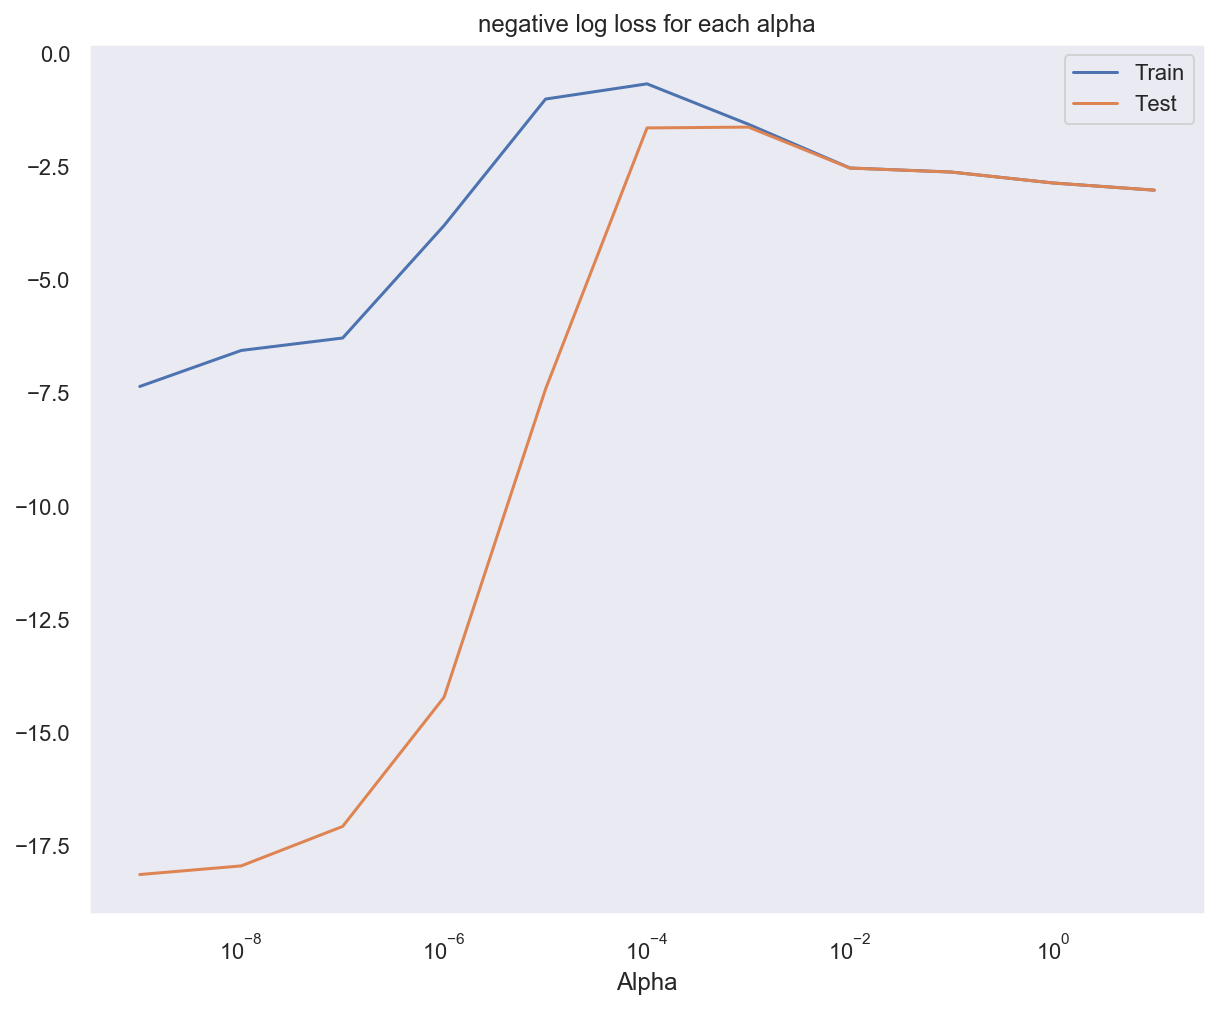

In [29]:
plt.plot(param_grid['estimator__alpha'], model.cv_results_['mean_train_neg_log_loss'], label='Train')
plt.plot(param_grid['estimator__alpha'], model.cv_results_['mean_test_neg_log_loss'], label='Test')
plt.xscale('log')
plt.grid()
plt.title('negative log loss for each alpha')
plt.xlabel('Alpha')
plt.legend() 
plt.show()

In [30]:
def plot_confusion_matrix(y_cv, y_pred):
    C = confusion_matrix(y_cv, y_pred)
    print("Percentage of misclassified points ",(len(y_cv)-np.trace(C))/len(y_cv)*100)
    A = (((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0, 1, 2, 3, 4, 5, 6]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",A.sum(axis=1))

In [ ]:
plot_confusion_matrix(y_cv, y_pred)

Percentage of misclassified points  43.17673378076063


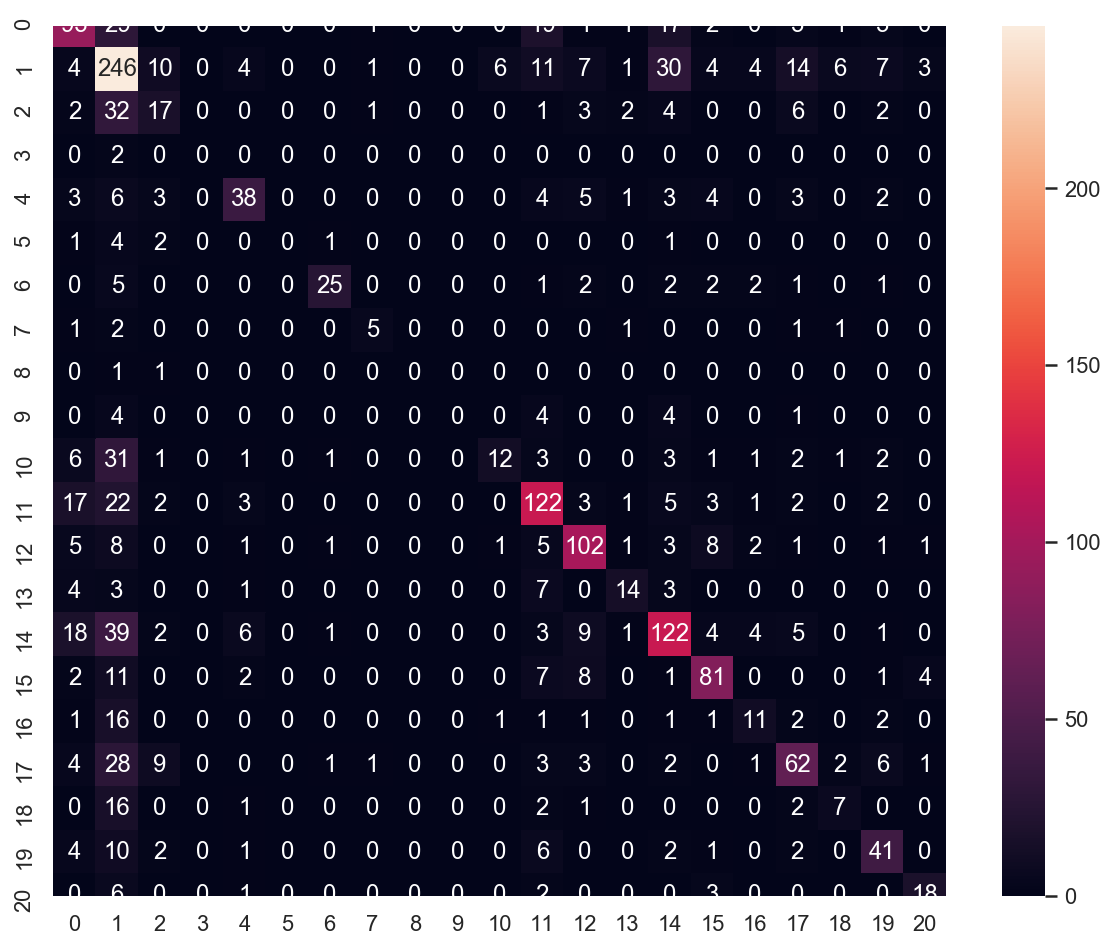

In [32]:
from sklearn.utils.multiclass import unique_labels
classes = unique_labels(y_cv, y_pred)
C = confusion_matrix(y_cv, y_pred, labels=classes)
print("Percentage of misclassified points ",(len(y_cv)-np.trace(C))/len(y_cv)*100)
df_cm = pd.DataFrame(confusion_matrix(y_cv, y_pred, labels=classes), columns=classes, index=classes)
sns.heatmap(df_cm, annot=True, fmt="d",)

+ Bad Taste/Flavor seems to have the worst precision.

### XgBoost Classifier

In [31]:
import xgboost as xgb

param_grid = {
'objective': 'multi:softmax',
'max_depth': [3, 5, 7],
'n_estimators': [50, 100, 200, 1000],
'learning_rate': [0.001, 0.01, 0.1, 0.5],
'subsample': [0.5, 0.7, 0.9, 1.0],
'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
'colsample_bylevel': [0.6, 0.7, 0.8, 1.0],
'min_child_weight': [1.0, 3.0, 5.0, 7.0],
'gamma': [0.0, 0.1, 1.0],
'reg_alpha': [0.1, 1.0, 10.0, 100.0, 200.0],
'reg_lambda': [0.1, 1.0, 10.0, 100.0, 200.0],
}

In [41]:
xgb_clf = xgb.XGBClassifier()
# Hyperparameter tuning using RandomizedSearchCV  cv
rscv_xgb_clf = RandomizedSearchCV(xgb_clf, param_grid, cv=StratifiedKFold(2, shuffle=True),
                                  scoring='accuracy', refit=False, n_iter=20, n_jobs=6,verbose=2)
rscv_xgb_clf.fit(X_train_vectorized, y_train)
rscv_xgb_clf.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 89.3min
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed: 115.3min finished


{'subsample': 0.9,
 'reg_lambda': 0.1,
 'reg_alpha': 1.0,
 'objective': 'i',
 'n_estimators': 200,
 'min_child_weight': 1.0,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 0.0,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.8}

In [42]:
rscv_xgb_clf.best_score_

0.5504675137856629

In [45]:
best_params = rscv_xgb_clf.best_params_

In [46]:
x_model = xgb.XGBClassifier(max_depth = best_params['max_depth'],
                           n_estimators = best_params['n_estimators'],
                           learning_rate = best_params['learning_rate'],
                           subsample = best_params['subsample'],
                           colsample_bytree = best_params['colsample_bytree'],
                           colsample_bylevel = best_params['colsample_bylevel'],
                           min_child_weight = best_params['min_child_weight'],
                           gamma = best_params['gamma'],
                           reg_alpha = best_params['reg_alpha'],
                           reg_lambda = best_params['reg_lambda'], nthread=4, n_jobs=-1)
x_model.fit(X_train_vectorized, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=200, n_jobs=-1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=1.0, reg_lambda=0.1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [47]:
y_pred = x_model.predict(X_cv_vectorized)

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
#print("Log loss ",log_loss(y_cv,y_pred))

precision = precision_score(y_cv, y_pred, average='micro')
recall = recall_score(y_cv, y_pred, average='micro')
f1 = f1_score(y_cv, y_pred, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_cv, y_pred, average='macro')
recall = recall_score(y_cv, y_pred, average='macro')
f1 = f1_score(y_cv, y_pred, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (classification_report(y_cv, y_pred))


print("Time taken to run this cell :", dt.datetime.now() - start)

Accuracy : 0.5542505592841164
Hamming loss  0.4457494407158837
Micro-average quality numbers
Precision: 0.5543, Recall: 0.5543, F1-measure: 0.5543
Macro-average quality numbers
Precision: 0.5644, Recall: 0.4936, F1-measure: 0.5132
              precision    recall  f1-score   support

           0       0.45      0.48      0.47       170
           1       0.56      0.56      0.56       358
           2       0.33      0.39      0.36        70
           3       1.00      0.50      0.67         2
           4       0.56      0.56      0.56        72
           5       0.20      0.11      0.14         9
           6       0.81      0.61      0.69        41
           7       0.53      0.73      0.62        11
           8       0.50      0.50      0.50         2
           9       0.67      0.31      0.42        13
          10       0.42      0.25      0.31        65
          11       0.71      0.59      0.64       183
          12       0.74      0.66      0.70       140
          13

In [48]:
#feature importances
x_model.get_booster().get_score(importance_type='weight') #using get_booster() instead of booster().

{'f1051': 169,
 'f588': 64,
 'f1020': 82,
 'f1031': 276,
 'f32': 251,
 'f1074': 716,
 'f758': 412,
 'f701': 60,
 'f1088': 459,
 'f1049': 318,
 'f508': 116,
 'f612': 733,
 'f317': 439,
 'f1107': 217,
 'f1018': 187,
 'f881': 58,
 'f897': 639,
 'f899': 222,
 'f907': 223,
 'f58': 42,
 'f906': 298,
 'f326': 147,
 'f734': 119,
 'f736': 216,
 'f105': 136,
 'f287': 205,
 'f675': 9,
 'f863': 2,
 'f327': 49,
 'f1035': 226,
 'f322': 302,
 'f661': 184,
 'f902': 285,
 'f725': 184,
 'f199': 99,
 'f755': 257,
 'f582': 107,
 'f672': 101,
 'f750': 79,
 'f1064': 51,
 'f566': 135,
 'f914': 76,
 'f695': 53,
 'f1091': 7,
 'f637': 188,
 'f684': 85,
 'f633': 113,
 'f677': 82,
 'f930': 116,
 'f732': 217,
 'f1152': 95,
 'f335': 78,
 'f961': 210,
 'f757': 23,
 'f688': 11,
 'f494': 152,
 'f307': 82,
 'f888': 13,
 'f981': 96,
 'f1042': 262,
 'f451': 43,
 'f1057': 223,
 'f1136': 251,
 'f1048': 173,
 'f1071': 39,
 'f1067': 268,
 'f480': 175,
 'f642': 161,
 'f487': 69,
 'f1153': 121,
 'f805': 251,
 'f822': 104,
 'f4

In [ ]:
plt.plot(param_grid['estimator__alpha'], model.cv_results_['mean_train_neg_log_loss'], label='Train')
plt.plot(param_grid['estimator__alpha'], model.cv_results_['mean_test_neg_log_loss'], label='Test')
plt.xscale('log')
plt.grid()
plt.title('negative log loss for each alpha')
plt.xlabel('Alpha')
plt.legend() 
plt.show()

In [70]:
import xgboost as xgb
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

dtrain = xgb.DMatrix(X_train_sdf1, feature_names=X_train_sdf1.columns, label=y_train) #, feature_types='Float-64'
dtest = xgb.DMatrix(X_cv_sdf1, feature_names=X_cv_sdf1.columns)

In [50]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'mlogloss',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'num_class':21
             }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the mlogloss 
    return -1.0 * cv_result['test-mlogloss-mean'].iloc[-1]

In [51]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)}, verbose=0)
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

[02:53:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:53:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:53:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:53:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:53:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[02:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:53:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[02:53:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:53:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:53:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[02:53:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:53:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[02:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:53:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:53:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:53:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[02:53:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[02:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=4
[02:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:54:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:54:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:54:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:54:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[02:54:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:54:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:54:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:54:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:54:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[02:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[02:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[02:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:54:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[02:54:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:54:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[02:54:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[02:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[02:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:54:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:54:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:54:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[02:54:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[02:54:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:54:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=4
[02:54:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:54:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:54:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[02:54:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[02:54:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[02:54:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[02:54:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:54:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 12 pruned nodes, max_depth=3
[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:55:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:55:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:55:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:55:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:55:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[02:55:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[02:55:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[02:55:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[02:55:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:55:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:55:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[02:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[02:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[02:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:56:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:56:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:56:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:56:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=4
[02:56:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:56:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:56:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[02:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:56:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:56:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:56:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:56:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[02:56:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:56:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:56:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:56:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[02:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:56:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 14 pruned nodes, max_depth=3
[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:56:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[02:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[02:56:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[02:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[02:56:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=6
[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[02:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[02:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:57:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[02:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[02:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[02:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[02:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=6
[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=6
[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=6
[02:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[02:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[02:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[02:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[02:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=6
[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=6
[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=6
[02:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=6
[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=5
[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[02:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=6
[02:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:57:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[02:57:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:57:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[02:57:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:57:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:57:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:57:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=6
[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=6
[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=6
[02:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=6
[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=6
[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=6
[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=6
[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:57:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=6
[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=6
[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=6
[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=6
[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=6
[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=6
[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[02:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=5
[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=6
[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=6
[02:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=6
[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 4 pruned nodes, max_depth=6
[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=6
[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=6
[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=6
[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=6
[02:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[02:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=6
[02:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[02:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=6
[02:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=6
[02:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=6
[02:58:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=6
[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=6
[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=6
[02:58:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=6
[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[02:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:58:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[02:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=6
[02:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[02:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=6
[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=6
[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=6
[02:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=6
[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=6
[02:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[02:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=6
[02:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, max_depth=6
[02:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=6
[02:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:58:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=6
[02:58:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, max_depth=6
[02:58:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, max_depth=6
[02:58:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[02:58:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[02:58:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=6
[02:58:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=6
[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_depth=6
[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=6
[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[02:58:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=6
[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=5
[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[02:58:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=6
[02:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=6
[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=6
[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=6
[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[02:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=6
[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=6
[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=6
[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=6
[02:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:58:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=6
[02:58:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=6
[02:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=6
[02:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=6
[02:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=6
[02:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=6
[02:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=6
[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=6
[02:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=6
[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=6
[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=5
[02:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[02:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=6
[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[02:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, max_depth=6
[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=6
[02:59:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=6
[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=6
[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=6
[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:59:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=6
[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=6
[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 12 pruned nodes, max_depth=6
[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=6
[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=6
[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[02:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=5
[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=6
[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=6
[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 14 pruned nodes, max_depth=6
[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=6
[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=6
[02:59:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=6
[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=6
[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:59:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[02:59:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[02:59:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=6
[02:59:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=6
[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=6
[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[02:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=6
[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=6
[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=6
[02:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=6
[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=6
[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=6
[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=6
[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=6
[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=6
[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=6
[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=5
[02:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[02:59:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:59:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[02:59:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=5
[02:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=6
[02:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=6
[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=6
[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[02:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=6
[02:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=6
[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=6
[02:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=6
[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 10 pruned nodes, max_depth=6
[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=6
[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=6
[02:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[03:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:00:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:00:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[03:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[03:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[03:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[03:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[03:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[03:01:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:01:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:01:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[03:01:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[03:01:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[03:01:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[03:01:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[03:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[03:01:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:01:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:01:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:02:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:02:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[03:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:02:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[03:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[03:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=4
[03:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[03:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=3
[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:03:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[03:03:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:03:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[03:03:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[03:03:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[03:03:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:03:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[03:03:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[03:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[03:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[03:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=2
[03:03:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:04:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:04:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:04:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:04:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:04:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:04:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:05:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:05:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:05:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:05:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:05:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:05:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:05:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:05:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:05:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:05:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:05:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:05:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:05:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:05:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:05:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=2
[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:06:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:06:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:06:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:06:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:06:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:06:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:06:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:06:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:06:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[03:07:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:07:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[03:07:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:07:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:07:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=2
[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:08:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:08:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:08:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:08:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:08:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:08:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:09:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[03:09:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=2
[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:09:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:09:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:10:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:10:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:10:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:10:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:10:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:10:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:11:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:11:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:11:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:11:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:12:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:12:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:12:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:12:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:12:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:12:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:12:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=2
[03:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:13:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:13:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:13:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:13:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:13:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:13:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:14:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:14:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:14:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:14:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:14:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:14:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:14:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:14:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:14:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:14:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:14:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:14:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:14:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:14:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:14:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=2
[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:15:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:15:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:15:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:15:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:15:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:15:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[03:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:15:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:15:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[03:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:16:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[03:16:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:16:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:16:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:16:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[03:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:16:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:16:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:16:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:16:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:16:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:16:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:16:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:17:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:17:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[03:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:17:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[03:17:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:17:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:18:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:18:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:18:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:18:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:18:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:18:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:18:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:18:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:18:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[03:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[03:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:19:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:19:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[03:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[03:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:19:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[03:19:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[03:19:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[03:19:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[03:19:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[03:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

In [59]:
xgb_bo.max['params']

{'colsample_bytree': 0.9, 'gamma': 1.0, 'max_depth': 3.0}

In [71]:
%%time
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth value from float to int
params['max_depth']= int(params['max_depth'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
classifier2 = XGBClassifier(**params,n_jobs=-1).fit(X_train_sdf1, y_train)

{'colsample_bytree': 0.9, 'gamma': 1.0, 'max_depth': 3.0}
Wall time: 2min 45s


In [72]:
#predicting for training set
y_pred = classifier2.predict(X_cv_sdf1)

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
#print("Log loss ",log_loss(y_cv,y_pred))

precision = precision_score(y_cv, y_pred, average='micro')
recall = recall_score(y_cv, y_pred, average='micro')
f1 = f1_score(y_cv, y_pred, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_cv, y_pred, average='macro')
recall = recall_score(y_cv, y_pred, average='macro')
f1 = f1_score(y_cv, y_pred, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (classification_report(y_cv, y_pred))


print("Time taken to run this cell :", dt.datetime.now() - start)

Accuracy : 0.5178970917225951
Hamming loss  0.48210290827740493
Micro-average quality numbers
Precision: 0.5179, Recall: 0.5179, F1-measure: 0.5179
Macro-average quality numbers
Precision: 0.5160, Recall: 0.4238, F1-measure: 0.4535
              precision    recall  f1-score   support

           0       0.55      0.46      0.50       170
           1       0.50      0.59      0.54       358
           2       0.24      0.31      0.27        70
           3       1.00      0.50      0.67         2
           4       0.51      0.46      0.48        72
           5       0.17      0.11      0.13         9
           6       0.74      0.56      0.64        41
           7       0.60      0.55      0.57        11
           8       0.00      0.00      0.00         2
           9       0.75      0.23      0.35        13
          10       0.42      0.31      0.35        65
          11       0.66      0.64      0.65       183
          12       0.68      0.66      0.67       140
          1

### Embedding Dimension - Hyperparamter
The choice of embedding dimension is optional, essentially it is a hyperparamter that one need to choose beforehand and investigate. One rule of thumb is to choose half of the cardinality of the categorical feature if that is up to 50 in length.

In [17]:
X_train['Preprocessed_Review_Text'].nunique() #to find out no. of unique rows.

3188

In [9]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def load_embeddings(path):
    with open(path, encoding='utf-8') as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

def build_embedding_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [10]:
embedding_files = [r'C:\Users\avinash\IPython notes\glove.840B.300d\glove.840B.300d.txt'] #glove.6B.300d.txt

In [11]:
MAX_LEN=128
tokenizer_text = Tokenizer(lower = True, filters='')
tokenizer_text.fit_on_texts(list(df_train['review_and_title_preprocessed']))
transform_train_text = tokenizer_text.texts_to_sequences(list(df_train['review_and_title_preprocessed']))
transform_train_text = pad_sequences(transform_train_text, maxlen=MAX_LEN)
print(np.shape(transform_train_text))

(5959, 128)


In [12]:
transform_test_text = tokenizer_text.texts_to_sequences(list(df_test['review_and_title_preprocessed']))
transform_test_text = pad_sequences(transform_test_text, maxlen=MAX_LEN)
print(np.shape(transform_test_text))

(2553, 128)


In [13]:
word_index_text = tokenizer_text.word_index
total_vocab_text = len(word_index_text) + 1
embedding_size = 300

In [14]:
%%time
embedding_matrix = np.concatenate([build_embedding_matrix(tokenizer_text.word_index, f) for f in embedding_files], axis=-1)

Wall time: 3min 26s


In [15]:
np.save('embedding_matrix',embedding_matrix)

In [16]:
embedding_matrix.shape

(7553, 300)

In [ ]:
inputs_text = Input(shape=(MAX_LEN,))
embedding_text = Embedding(total_vocab_text,embedding_size,weights=[embedding_matrix],input_length=MAX_LEN,trainable=False)(inputs_text)
lstm_text = LSTM(128,return_sequences=True)(embedding_text)
lstm_text = LSTM(64,return_sequences=True)(lstm_text)
flatten_text = Flatten()(lstm_text)
dense128 = Dense(128, activation='relu')(flatten_text)
dropout = Dropout(0.2)(dense128)
dense64 = Dense(64, activation='relu')(dense128)
dropout = Dropout(0.2)(dense64)
predictions = Dense(21, activation='softmax')(dropout)
model = Model(inputs=[inputs_text], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc', 'top_k_categorical_accuracy']) #,top_3_accuracy

model.summary()

In [25]:
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([transform_train_text], batch_size=32, y=to_categorical(y_true,num_classes=21), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=20, callbacks=[checkpointer])

Train on 4469 samples, validate on 1490 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3456/4469 [======================>.......] - ETA: 5:30 - loss: 3.0357 - acc: 0.0938 - top_k_categorical_accuracy: 0.21 - ETA: 3:06 - loss: 2.9891 - acc: 0.1250 - top_k_categorical_accuracy: 0.37 - ETA: 2:18 - loss: 3.0183 - acc: 0.1250 - top_k_categorical_accuracy: 0.35 - ETA: 1:52 - loss: 3.0155 - acc: 0.0938 - top_k_categorical_accuracy: 0.34 - ETA: 1:38 - loss: 3.0507 - acc: 0.0938 - top_k_categorical_accuracy: 0.33 - ETA: 1:28 - loss: 3.0343 - acc: 0.1146 - top_k_categorical_accuracy: 0.35 - ETA: 1:21 - loss: 3.0299 - acc: 0.1339 - top_k_categorical_accuracy: 0.37 - ETA: 1:16 - loss: 3.0079 - acc: 0.1484 - top_k_categorical_accuracy: 0.41 - ETA: 1:13 - loss: 3.0050 - acc: 0.1528 - top_k_categorical_accuracy: 0.41 - ETA: 1:09 - loss: 2.9892 - acc: 0.1594 - top_k_categorical_accuracy: 0.43 - ETA: 1:06 - loss: 2.9873 - acc: 0.1534 - top_k_categorical_accuracy: 0.43 - ETA: 1:04 - 

3456/4469 [======================>.......] - ETA: 40s - loss: 2.4386 - acc: 0.3125 - top_k_categorical_accuracy: 0.500 - ETA: 40s - loss: 2.3612 - acc: 0.2969 - top_k_categorical_accuracy: 0.671 - ETA: 43s - loss: 2.3572 - acc: 0.2708 - top_k_categorical_accuracy: 0.687 - ETA: 42s - loss: 2.2465 - acc: 0.2969 - top_k_categorical_accuracy: 0.726 - ETA: 41s - loss: 2.2275 - acc: 0.3063 - top_k_categorical_accuracy: 0.743 - ETA: 41s - loss: 2.2364 - acc: 0.3021 - top_k_categorical_accuracy: 0.744 - ETA: 40s - loss: 2.2180 - acc: 0.3170 - top_k_categorical_accuracy: 0.741 - ETA: 40s - loss: 2.1602 - acc: 0.3359 - top_k_categorical_accuracy: 0.753 - ETA: 40s - loss: 2.1498 - acc: 0.3438 - top_k_categorical_accuracy: 0.763 - ETA: 40s - loss: 2.1475 - acc: 0.3438 - top_k_categorical_accuracy: 0.759 - ETA: 40s - loss: 2.1146 - acc: 0.3665 - top_k_categorical_accuracy: 0.764 - ETA: 40s - loss: 2.1015 - acc: 0.3672 - top_k_categorical_accuracy: 0.770 - ETA: 39s - loss: 2.0917 - acc: 0.3726 - top

4448/4469 [============================>.] - ETA: 9s - loss: 1.9825 - acc: 0.4154 - top_k_categorical_accuracy: 0.78 - ETA: 9s - loss: 1.9858 - acc: 0.4139 - top_k_categorical_accuracy: 0.78 - ETA: 8s - loss: 1.9860 - acc: 0.4136 - top_k_categorical_accuracy: 0.78 - ETA: 8s - loss: 1.9872 - acc: 0.4132 - top_k_categorical_accuracy: 0.78 - ETA: 8s - loss: 1.9877 - acc: 0.4132 - top_k_categorical_accuracy: 0.78 - ETA: 7s - loss: 1.9853 - acc: 0.4137 - top_k_categorical_accuracy: 0.78 - ETA: 7s - loss: 1.9857 - acc: 0.4130 - top_k_categorical_accuracy: 0.78 - ETA: 7s - loss: 1.9866 - acc: 0.4130 - top_k_categorical_accuracy: 0.78 - ETA: 7s - loss: 1.9882 - acc: 0.4135 - top_k_categorical_accuracy: 0.78 - ETA: 6s - loss: 1.9924 - acc: 0.4129 - top_k_categorical_accuracy: 0.78 - ETA: 6s - loss: 1.9915 - acc: 0.4133 - top_k_categorical_accuracy: 0.78 - ETA: 6s - loss: 1.9900 - acc: 0.4143 - top_k_categorical_accuracy: 0.78 - ETA: 5s - loss: 1.9882 - acc: 0.4148 - top_k_categorical_accuracy: 

3456/4469 [======================>.......] - ETA: 46s - loss: 1.3522 - acc: 0.5938 - top_k_categorical_accuracy: 0.906 - ETA: 46s - loss: 1.4252 - acc: 0.6094 - top_k_categorical_accuracy: 0.890 - ETA: 44s - loss: 1.3579 - acc: 0.6250 - top_k_categorical_accuracy: 0.885 - ETA: 43s - loss: 1.3357 - acc: 0.6172 - top_k_categorical_accuracy: 0.875 - ETA: 44s - loss: 1.3861 - acc: 0.6125 - top_k_categorical_accuracy: 0.868 - ETA: 43s - loss: 1.3741 - acc: 0.6042 - top_k_categorical_accuracy: 0.875 - ETA: 44s - loss: 1.3812 - acc: 0.5982 - top_k_categorical_accuracy: 0.861 - ETA: 44s - loss: 1.4185 - acc: 0.5781 - top_k_categorical_accuracy: 0.867 - ETA: 43s - loss: 1.4351 - acc: 0.5625 - top_k_categorical_accuracy: 0.861 - ETA: 43s - loss: 1.4516 - acc: 0.5594 - top_k_categorical_accuracy: 0.871 - ETA: 43s - loss: 1.4447 - acc: 0.5568 - top_k_categorical_accuracy: 0.872 - ETA: 42s - loss: 1.4533 - acc: 0.5469 - top_k_categorical_accuracy: 0.880 - ETA: 42s - loss: 1.4909 - acc: 0.5312 - top

4448/4469 [============================>.] - ETA: 10s - loss: 1.5159 - acc: 0.5344 - top_k_categorical_accuracy: 0.890 - ETA: 9s - loss: 1.5136 - acc: 0.5347 - top_k_categorical_accuracy: 0.890 - ETA: 9s - loss: 1.5164 - acc: 0.5332 - top_k_categorical_accuracy: 0.89 - ETA: 9s - loss: 1.5192 - acc: 0.5318 - top_k_categorical_accuracy: 0.89 - ETA: 8s - loss: 1.5208 - acc: 0.5315 - top_k_categorical_accuracy: 0.89 - ETA: 8s - loss: 1.5220 - acc: 0.5310 - top_k_categorical_accuracy: 0.89 - ETA: 8s - loss: 1.5215 - acc: 0.5312 - top_k_categorical_accuracy: 0.89 - ETA: 7s - loss: 1.5213 - acc: 0.5312 - top_k_categorical_accuracy: 0.89 - ETA: 7s - loss: 1.5227 - acc: 0.5315 - top_k_categorical_accuracy: 0.89 - ETA: 7s - loss: 1.5240 - acc: 0.5318 - top_k_categorical_accuracy: 0.89 - ETA: 6s - loss: 1.5229 - acc: 0.5320 - top_k_categorical_accuracy: 0.89 - ETA: 6s - loss: 1.5231 - acc: 0.5326 - top_k_categorical_accuracy: 0.89 - ETA: 6s - loss: 1.5209 - acc: 0.5328 - top_k_categorical_accurac

3456/4469 [======================>.......] - ETA: 50s - loss: 0.6556 - acc: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 49s - loss: 1.0175 - acc: 0.6250 - top_k_categorical_accuracy: 0.953 - ETA: 49s - loss: 0.9514 - acc: 0.6562 - top_k_categorical_accuracy: 0.968 - ETA: 49s - loss: 0.9896 - acc: 0.6484 - top_k_categorical_accuracy: 0.953 - ETA: 48s - loss: 1.0014 - acc: 0.6562 - top_k_categorical_accuracy: 0.943 - ETA: 48s - loss: 0.9746 - acc: 0.6667 - top_k_categorical_accuracy: 0.947 - ETA: 47s - loss: 1.0648 - acc: 0.6384 - top_k_categorical_accuracy: 0.937 - ETA: 46s - loss: 1.0529 - acc: 0.6406 - top_k_categorical_accuracy: 0.937 - ETA: 46s - loss: 1.0796 - acc: 0.6424 - top_k_categorical_accuracy: 0.934 - ETA: 45s - loss: 1.0596 - acc: 0.6500 - top_k_categorical_accuracy: 0.940 - ETA: 45s - loss: 1.0677 - acc: 0.6506 - top_k_categorical_accuracy: 0.940 - ETA: 46s - loss: 1.0585 - acc: 0.6562 - top_k_categorical_accuracy: 0.945 - ETA: 46s - loss: 1.0907 - acc: 0.6538 - top

4448/4469 [============================>.] - ETA: 11s - loss: 1.2095 - acc: 0.6001 - top_k_categorical_accuracy: 0.941 - ETA: 10s - loss: 1.2098 - acc: 0.6000 - top_k_categorical_accuracy: 0.941 - ETA: 10s - loss: 1.2119 - acc: 0.5991 - top_k_categorical_accuracy: 0.941 - ETA: 10s - loss: 1.2125 - acc: 0.5988 - top_k_categorical_accuracy: 0.942 - ETA: 9s - loss: 1.2144 - acc: 0.5982 - top_k_categorical_accuracy: 0.941 - ETA: 9s - loss: 1.2142 - acc: 0.5976 - top_k_categorical_accuracy: 0.94 - ETA: 8s - loss: 1.2142 - acc: 0.5965 - top_k_categorical_accuracy: 0.94 - ETA: 8s - loss: 1.2147 - acc: 0.5962 - top_k_categorical_accuracy: 0.94 - ETA: 8s - loss: 1.2164 - acc: 0.5964 - top_k_categorical_accuracy: 0.94 - ETA: 7s - loss: 1.2162 - acc: 0.5964 - top_k_categorical_accuracy: 0.94 - ETA: 7s - loss: 1.2142 - acc: 0.5969 - top_k_categorical_accuracy: 0.94 - ETA: 7s - loss: 1.2135 - acc: 0.5979 - top_k_categorical_accuracy: 0.94 - ETA: 6s - loss: 1.2121 - acc: 0.5984 - top_k_categorical_a

3456/4469 [======================>.......] - ETA: 44s - loss: 0.9783 - acc: 0.6875 - top_k_categorical_accuracy: 1.000 - ETA: 43s - loss: 0.8958 - acc: 0.7031 - top_k_categorical_accuracy: 1.000 - ETA: 44s - loss: 0.9263 - acc: 0.6979 - top_k_categorical_accuracy: 0.989 - ETA: 43s - loss: 0.9239 - acc: 0.6953 - top_k_categorical_accuracy: 0.992 - ETA: 43s - loss: 0.9273 - acc: 0.6875 - top_k_categorical_accuracy: 0.993 - ETA: 43s - loss: 0.9808 - acc: 0.6719 - top_k_categorical_accuracy: 0.989 - ETA: 44s - loss: 1.0098 - acc: 0.6607 - top_k_categorical_accuracy: 0.986 - ETA: 43s - loss: 0.9937 - acc: 0.6602 - top_k_categorical_accuracy: 0.988 - ETA: 42s - loss: 0.9988 - acc: 0.6528 - top_k_categorical_accuracy: 0.989 - ETA: 42s - loss: 0.9879 - acc: 0.6594 - top_k_categorical_accuracy: 0.981 - ETA: 42s - loss: 0.9799 - acc: 0.6619 - top_k_categorical_accuracy: 0.980 - ETA: 41s - loss: 0.9702 - acc: 0.6719 - top_k_categorical_accuracy: 0.976 - ETA: 41s - loss: 0.9442 - acc: 0.6851 - top

4448/4469 [============================>.] - ETA: 10s - loss: 1.0173 - acc: 0.6368 - top_k_categorical_accuracy: 0.971 - ETA: 9s - loss: 1.0188 - acc: 0.6361 - top_k_categorical_accuracy: 0.971 - ETA: 9s - loss: 1.0197 - acc: 0.6357 - top_k_categorical_accuracy: 0.97 - ETA: 9s - loss: 1.0224 - acc: 0.6348 - top_k_categorical_accuracy: 0.97 - ETA: 8s - loss: 1.0219 - acc: 0.6350 - top_k_categorical_accuracy: 0.97 - ETA: 8s - loss: 1.0233 - acc: 0.6346 - top_k_categorical_accuracy: 0.97 - ETA: 8s - loss: 1.0230 - acc: 0.6340 - top_k_categorical_accuracy: 0.97 - ETA: 7s - loss: 1.0241 - acc: 0.6336 - top_k_categorical_accuracy: 0.97 - ETA: 7s - loss: 1.0256 - acc: 0.6325 - top_k_categorical_accuracy: 0.97 - ETA: 7s - loss: 1.0276 - acc: 0.6322 - top_k_categorical_accuracy: 0.97 - ETA: 6s - loss: 1.0288 - acc: 0.6316 - top_k_categorical_accuracy: 0.97 - ETA: 6s - loss: 1.0282 - acc: 0.6313 - top_k_categorical_accuracy: 0.97 - ETA: 6s - loss: 1.0303 - acc: 0.6309 - top_k_categorical_accurac

3456/4469 [======================>.......] - ETA: 44s - loss: 0.8620 - acc: 0.6875 - top_k_categorical_accuracy: 1.000 - ETA: 47s - loss: 0.8718 - acc: 0.6406 - top_k_categorical_accuracy: 0.984 - ETA: 47s - loss: 0.9032 - acc: 0.6562 - top_k_categorical_accuracy: 0.979 - ETA: 45s - loss: 0.9040 - acc: 0.6484 - top_k_categorical_accuracy: 0.976 - ETA: 46s - loss: 0.8737 - acc: 0.6687 - top_k_categorical_accuracy: 0.981 - ETA: 47s - loss: 0.8937 - acc: 0.6615 - top_k_categorical_accuracy: 0.974 - ETA: 46s - loss: 0.8547 - acc: 0.6696 - top_k_categorical_accuracy: 0.977 - ETA: 45s - loss: 0.8292 - acc: 0.6758 - top_k_categorical_accuracy: 0.980 - ETA: 46s - loss: 0.8086 - acc: 0.6840 - top_k_categorical_accuracy: 0.982 - ETA: 45s - loss: 0.8150 - acc: 0.6906 - top_k_categorical_accuracy: 0.981 - ETA: 45s - loss: 0.8067 - acc: 0.7017 - top_k_categorical_accuracy: 0.983 - ETA: 44s - loss: 0.7905 - acc: 0.7057 - top_k_categorical_accuracy: 0.984 - ETA: 43s - loss: 0.8070 - acc: 0.6995 - top

4448/4469 [============================>.] - ETA: 10s - loss: 0.8772 - acc: 0.6588 - top_k_categorical_accuracy: 0.980 - ETA: 9s - loss: 0.8784 - acc: 0.6585 - top_k_categorical_accuracy: 0.981 - ETA: 9s - loss: 0.8821 - acc: 0.6568 - top_k_categorical_accuracy: 0.98 - ETA: 9s - loss: 0.8846 - acc: 0.6557 - top_k_categorical_accuracy: 0.98 - ETA: 8s - loss: 0.8853 - acc: 0.6554 - top_k_categorical_accuracy: 0.98 - ETA: 8s - loss: 0.8865 - acc: 0.6552 - top_k_categorical_accuracy: 0.98 - ETA: 8s - loss: 0.8875 - acc: 0.6552 - top_k_categorical_accuracy: 0.98 - ETA: 7s - loss: 0.8868 - acc: 0.6554 - top_k_categorical_accuracy: 0.98 - ETA: 7s - loss: 0.8868 - acc: 0.6554 - top_k_categorical_accuracy: 0.98 - ETA: 7s - loss: 0.8890 - acc: 0.6549 - top_k_categorical_accuracy: 0.98 - ETA: 6s - loss: 0.8912 - acc: 0.6539 - top_k_categorical_accuracy: 0.98 - ETA: 6s - loss: 0.8932 - acc: 0.6531 - top_k_categorical_accuracy: 0.97 - ETA: 6s - loss: 0.8938 - acc: 0.6529 - top_k_categorical_accurac

3456/4469 [======================>.......] - ETA: 1:06 - loss: 0.7521 - acc: 0.6562 - top_k_categorical_accuracy: 0.96 - ETA: 59s - loss: 0.7811 - acc: 0.6562 - top_k_categorical_accuracy: 0.9531 - ETA: 56s - loss: 0.7873 - acc: 0.6562 - top_k_categorical_accuracy: 0.958 - ETA: 55s - loss: 0.7663 - acc: 0.6484 - top_k_categorical_accuracy: 0.968 - ETA: 54s - loss: 0.7191 - acc: 0.6625 - top_k_categorical_accuracy: 0.975 - ETA: 53s - loss: 0.7388 - acc: 0.6667 - top_k_categorical_accuracy: 0.974 - ETA: 55s - loss: 0.7229 - acc: 0.6830 - top_k_categorical_accuracy: 0.977 - ETA: 55s - loss: 0.7277 - acc: 0.6758 - top_k_categorical_accuracy: 0.980 - ETA: 56s - loss: 0.7182 - acc: 0.6771 - top_k_categorical_accuracy: 0.982 - ETA: 56s - loss: 0.7077 - acc: 0.6875 - top_k_categorical_accuracy: 0.984 - ETA: 55s - loss: 0.7169 - acc: 0.6761 - top_k_categorical_accuracy: 0.985 - ETA: 55s - loss: 0.7147 - acc: 0.6719 - top_k_categorical_accuracy: 0.987 - ETA: 54s - loss: 0.7146 - acc: 0.6731 - to

4448/4469 [============================>.] - ETA: 12s - loss: 0.7902 - acc: 0.6631 - top_k_categorical_accuracy: 0.988 - ETA: 12s - loss: 0.7880 - acc: 0.6634 - top_k_categorical_accuracy: 0.988 - ETA: 12s - loss: 0.7874 - acc: 0.6636 - top_k_categorical_accuracy: 0.988 - ETA: 11s - loss: 0.7871 - acc: 0.6635 - top_k_categorical_accuracy: 0.988 - ETA: 11s - loss: 0.7873 - acc: 0.6634 - top_k_categorical_accuracy: 0.988 - ETA: 10s - loss: 0.7874 - acc: 0.6628 - top_k_categorical_accuracy: 0.988 - ETA: 10s - loss: 0.7872 - acc: 0.6622 - top_k_categorical_accuracy: 0.988 - ETA: 9s - loss: 0.7902 - acc: 0.6614 - top_k_categorical_accuracy: 0.987 - ETA: 9s - loss: 0.7912 - acc: 0.6608 - top_k_categorical_accuracy: 0.98 - ETA: 9s - loss: 0.7909 - acc: 0.6605 - top_k_categorical_accuracy: 0.98 - ETA: 8s - loss: 0.7916 - acc: 0.6605 - top_k_categorical_accuracy: 0.98 - ETA: 8s - loss: 0.7943 - acc: 0.6596 - top_k_categorical_accuracy: 0.98 - ETA: 7s - loss: 0.7949 - acc: 0.6593 - top_k_categor

3456/4469 [======================>.......] - ETA: 54s - loss: 0.7487 - acc: 0.5625 - top_k_categorical_accuracy: 1.000 - ETA: 58s - loss: 0.7468 - acc: 0.6094 - top_k_categorical_accuracy: 1.000 - ETA: 57s - loss: 0.7574 - acc: 0.5938 - top_k_categorical_accuracy: 1.000 - ETA: 57s - loss: 0.7181 - acc: 0.6328 - top_k_categorical_accuracy: 1.000 - ETA: 57s - loss: 0.7150 - acc: 0.6438 - top_k_categorical_accuracy: 1.000 - ETA: 57s - loss: 0.7126 - acc: 0.6458 - top_k_categorical_accuracy: 1.000 - ETA: 57s - loss: 0.7188 - acc: 0.6652 - top_k_categorical_accuracy: 0.995 - ETA: 56s - loss: 0.7118 - acc: 0.6719 - top_k_categorical_accuracy: 0.996 - ETA: 56s - loss: 0.7027 - acc: 0.6736 - top_k_categorical_accuracy: 0.989 - ETA: 55s - loss: 0.7051 - acc: 0.6719 - top_k_categorical_accuracy: 0.990 - ETA: 55s - loss: 0.7264 - acc: 0.6676 - top_k_categorical_accuracy: 0.988 - ETA: 55s - loss: 0.7106 - acc: 0.6771 - top_k_categorical_accuracy: 0.989 - ETA: 54s - loss: 0.7082 - acc: 0.6755 - top

4448/4469 [============================>.] - ETA: 12s - loss: 0.7269 - acc: 0.6649 - top_k_categorical_accuracy: 0.992 - ETA: 12s - loss: 0.7278 - acc: 0.6639 - top_k_categorical_accuracy: 0.992 - ETA: 11s - loss: 0.7305 - acc: 0.6627 - top_k_categorical_accuracy: 0.992 - ETA: 11s - loss: 0.7318 - acc: 0.6621 - top_k_categorical_accuracy: 0.992 - ETA: 11s - loss: 0.7330 - acc: 0.6621 - top_k_categorical_accuracy: 0.992 - ETA: 10s - loss: 0.7342 - acc: 0.6623 - top_k_categorical_accuracy: 0.992 - ETA: 10s - loss: 0.7354 - acc: 0.6622 - top_k_categorical_accuracy: 0.991 - ETA: 9s - loss: 0.7358 - acc: 0.6624 - top_k_categorical_accuracy: 0.991 - ETA: 9s - loss: 0.7356 - acc: 0.6627 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.7383 - acc: 0.6615 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.7392 - acc: 0.6618 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.7387 - acc: 0.6615 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.7378 - acc: 0.6614 - top_k_categor

3456/4469 [======================>.......] - ETA: 48s - loss: 0.6555 - acc: 0.7188 - top_k_categorical_accuracy: 0.968 - ETA: 46s - loss: 0.6469 - acc: 0.6562 - top_k_categorical_accuracy: 0.984 - ETA: 46s - loss: 0.6187 - acc: 0.6979 - top_k_categorical_accuracy: 0.989 - ETA: 46s - loss: 0.6740 - acc: 0.6797 - top_k_categorical_accuracy: 0.984 - ETA: 45s - loss: 0.6618 - acc: 0.6938 - top_k_categorical_accuracy: 0.987 - ETA: 45s - loss: 0.6059 - acc: 0.7292 - top_k_categorical_accuracy: 0.989 - ETA: 45s - loss: 0.5930 - acc: 0.7366 - top_k_categorical_accuracy: 0.991 - ETA: 45s - loss: 0.5847 - acc: 0.7422 - top_k_categorical_accuracy: 0.992 - ETA: 45s - loss: 0.5688 - acc: 0.7431 - top_k_categorical_accuracy: 0.993 - ETA: 45s - loss: 0.5780 - acc: 0.7312 - top_k_categorical_accuracy: 0.993 - ETA: 44s - loss: 0.5881 - acc: 0.7216 - top_k_categorical_accuracy: 0.994 - ETA: 44s - loss: 0.6005 - acc: 0.7109 - top_k_categorical_accuracy: 0.994 - ETA: 44s - loss: 0.5910 - acc: 0.7115 - top

4448/4469 [============================>.] - ETA: 10s - loss: 0.6730 - acc: 0.6680 - top_k_categorical_accuracy: 0.993 - ETA: 10s - loss: 0.6735 - acc: 0.6679 - top_k_categorical_accuracy: 0.993 - ETA: 9s - loss: 0.6754 - acc: 0.6667 - top_k_categorical_accuracy: 0.993 - ETA: 9s - loss: 0.6755 - acc: 0.6669 - top_k_categorical_accuracy: 0.99 - ETA: 9s - loss: 0.6750 - acc: 0.6670 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6774 - acc: 0.6656 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6790 - acc: 0.6649 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6797 - acc: 0.6646 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6808 - acc: 0.6643 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6813 - acc: 0.6634 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6850 - acc: 0.6615 - top_k_categorical_accuracy: 0.99 - ETA: 6s - loss: 0.6862 - acc: 0.6615 - top_k_categorical_accuracy: 0.99 - ETA: 6s - loss: 0.6869 - acc: 0.6614 - top_k_categorical_accur

3456/4469 [======================>.......] - ETA: 45s - loss: 0.5397 - acc: 0.7188 - top_k_categorical_accuracy: 1.000 - ETA: 45s - loss: 0.6618 - acc: 0.6562 - top_k_categorical_accuracy: 1.000 - ETA: 45s - loss: 0.7189 - acc: 0.6667 - top_k_categorical_accuracy: 1.000 - ETA: 45s - loss: 0.7321 - acc: 0.6562 - top_k_categorical_accuracy: 1.000 - ETA: 45s - loss: 0.6909 - acc: 0.6687 - top_k_categorical_accuracy: 1.000 - ETA: 45s - loss: 0.7170 - acc: 0.6562 - top_k_categorical_accuracy: 1.000 - ETA: 44s - loss: 0.7134 - acc: 0.6562 - top_k_categorical_accuracy: 1.000 - ETA: 44s - loss: 0.7184 - acc: 0.6484 - top_k_categorical_accuracy: 1.000 - ETA: 44s - loss: 0.7252 - acc: 0.6528 - top_k_categorical_accuracy: 1.000 - ETA: 43s - loss: 0.7119 - acc: 0.6531 - top_k_categorical_accuracy: 0.996 - ETA: 43s - loss: 0.7036 - acc: 0.6534 - top_k_categorical_accuracy: 0.997 - ETA: 43s - loss: 0.6861 - acc: 0.6615 - top_k_categorical_accuracy: 0.997 - ETA: 42s - loss: 0.6822 - acc: 0.6611 - top

4448/4469 [============================>.] - ETA: 10s - loss: 0.6542 - acc: 0.6746 - top_k_categorical_accuracy: 0.996 - ETA: 10s - loss: 0.6532 - acc: 0.6750 - top_k_categorical_accuracy: 0.996 - ETA: 9s - loss: 0.6542 - acc: 0.6743 - top_k_categorical_accuracy: 0.996 - ETA: 9s - loss: 0.6534 - acc: 0.6747 - top_k_categorical_accuracy: 0.99 - ETA: 9s - loss: 0.6568 - acc: 0.6728 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6590 - acc: 0.6711 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6591 - acc: 0.6707 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6584 - acc: 0.6703 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6577 - acc: 0.6707 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6562 - acc: 0.6716 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6560 - acc: 0.6715 - top_k_categorical_accuracy: 0.99 - ETA: 6s - loss: 0.6556 - acc: 0.6719 - top_k_categorical_accuracy: 0.99 - ETA: 6s - loss: 0.6568 - acc: 0.6712 - top_k_categorical_accur

3456/4469 [======================>.......] - ETA: 1:01 - loss: 0.5421 - acc: 0.6562 - top_k_categorical_accuracy: 1.00 - ETA: 57s - loss: 0.5028 - acc: 0.6875 - top_k_categorical_accuracy: 1.0000 - ETA: 58s - loss: 0.4873 - acc: 0.7083 - top_k_categorical_accuracy: 1.000 - ETA: 58s - loss: 0.5430 - acc: 0.6797 - top_k_categorical_accuracy: 1.000 - ETA: 56s - loss: 0.5747 - acc: 0.6875 - top_k_categorical_accuracy: 1.000 - ETA: 57s - loss: 0.5978 - acc: 0.6771 - top_k_categorical_accuracy: 1.000 - ETA: 56s - loss: 0.6201 - acc: 0.6696 - top_k_categorical_accuracy: 1.000 - ETA: 56s - loss: 0.6055 - acc: 0.6914 - top_k_categorical_accuracy: 1.000 - ETA: 56s - loss: 0.5914 - acc: 0.7049 - top_k_categorical_accuracy: 1.000 - ETA: 56s - loss: 0.5781 - acc: 0.7125 - top_k_categorical_accuracy: 1.000 - ETA: 55s - loss: 0.5778 - acc: 0.7159 - top_k_categorical_accuracy: 1.000 - ETA: 56s - loss: 0.5923 - acc: 0.7057 - top_k_categorical_accuracy: 1.000 - ETA: 55s - loss: 0.5760 - acc: 0.7115 - to

4448/4469 [============================>.] - ETA: 11s - loss: 0.6345 - acc: 0.6749 - top_k_categorical_accuracy: 0.997 - ETA: 11s - loss: 0.6327 - acc: 0.6759 - top_k_categorical_accuracy: 0.997 - ETA: 10s - loss: 0.6333 - acc: 0.6751 - top_k_categorical_accuracy: 0.997 - ETA: 10s - loss: 0.6354 - acc: 0.6744 - top_k_categorical_accuracy: 0.997 - ETA: 10s - loss: 0.6349 - acc: 0.6751 - top_k_categorical_accuracy: 0.997 - ETA: 9s - loss: 0.6354 - acc: 0.6743 - top_k_categorical_accuracy: 0.997 - ETA: 9s - loss: 0.6350 - acc: 0.6745 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6362 - acc: 0.6748 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6366 - acc: 0.6747 - top_k_categorical_accuracy: 0.99 - ETA: 8s - loss: 0.6373 - acc: 0.6751 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6368 - acc: 0.6746 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6377 - acc: 0.6740 - top_k_categorical_accuracy: 0.99 - ETA: 7s - loss: 0.6389 - acc: 0.6741 - top_k_categorical

In [26]:
#Inverse transforming label encoded predicted labels.
final_pred = model.predict(transform_test_text)
final_pred = LE.inverse_transform(np.argmax(final_pred, axis=1))

In [27]:
final_pred

array(['Quality/Contaminated', 'Quality/Contaminated', 'Not Effective',
       ..., 'Allergic', 'Quality/Contaminated', 'Customer Service'],
      dtype=object)

In [52]:
submissions = pd.DataFrame(df_test[['Review Text', 'Review Title']])
submissions['topic'] = final_pred

In [54]:
submissions.to_csv('Submissions.csv')